https://github.com/roboflow/notebooks/blob/main/notebooks/how-to-run-different-vision-tasks-with-florence-2.ipynb

# Exploring Different Vision Tasks with Florence-2

---

[![Roboflow](https://raw.githubusercontent.com/roboflow-ai/notebooks/main/assets/badges/roboflow-blogpost.svg)](https://blog.roboflow.com/florence-2/)
[![arXiv](https://img.shields.io/badge/arXiv-2311.06242-b31b1b.svg)](https://arxiv.org/abs/2311.06242)

## Setup

### Configure your API keys

To run Florence-2, you need to provide your HuggingFace Token. Follow these steps:

- Open your [`HuggingFace Settings`](https://huggingface.co/settings) page. Click `Access Tokens` then `New Token` to generate new token.
- In Colab, go to the left pane and click on `Secrets` (🔑). Store HuggingFace Access Token under the name `HF_TOKEN`.

### Select the runtime

Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that. In case of any problems navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `T4 GPU`, and then click `Save`.

In [ ]:
!nvidia-smi

Sat May 10 10:38:33 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   64C    P8             11W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

### Install extra dependencies

 Let's download the model checkpoint and configure it so that you can fine-tune it later on.

In [ ]:
!pip install -q transformers flash_attn timm einops supervision==0.22.0rc1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 16.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.9/126.9 kB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 91.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 29.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 62.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 15.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 83.3 MB/s eta 0:00:00


### Download example data

**NOTE:** To make it easier for us to manage datasets, images and models we create a `HOME` constant.

In [ ]:
import os
HOME = os.getcwd()
print("HOME:", HOME)

HOME: /content


**NONE:** Let's download few example images. Feel free to use your images or videos.

In [ ]:
!mkdir -p {HOME}/data

!wget -q https://media.roboflow.com/notebooks/examples/dog.jpeg -P {HOME}/data
!wget -q https://media.roboflow.com/notebooks/examples/dog-2.jpeg -P {HOME}/data
!wget -q https://media.roboflow.com/notebooks/examples/dog-3.jpeg -P {HOME}/data
!wget -q https://media.roboflow.com/notebooks/examples/dog-4.jpeg -P {HOME}/data
!wget -q https://media.roboflow.com/inference/license_plate_1.jpg -P {HOME}/data
!wget -q https://media.roboflow.com/notebooks/examples/handwritten-text.jpg -P {HOME}/data

## Load pre-trained Florence-2 model

Load the model using `AutoModelForCausalLM` and the processor using `AutoProcessor` classes from the transformers library. Note that you need to pass `trust_remote_code` as `True` since this model is not a standard transformers model.

In [ ]:
import torch
from transformers import AutoModelForCausalLM, AutoProcessor

# CHECKPOINT = "microsoft/Florence-2-base-ft"
CHECKPOINT = "microsoft/Florence-2-large-ft"
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = AutoModelForCausalLM.from_pretrained(CHECKPOINT, trust_remote_code=True).to(DEVICE)
processor = AutoProcessor.from_pretrained(CHECKPOINT, trust_remote_code=True)

config.json:   0%|          | 0.00/2.44k [00:00<?, ?B/s]

configuration_florence2.py:   0%|          | 0.00/15.1k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/microsoft/Florence-2-large-ft:
- configuration_florence2.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


modeling_florence2.py:   0%|          | 0.00/127k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/microsoft/Florence-2-large-ft:
- modeling_florence2.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
/usr/local/lib/python3.11/dist-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


pytorch_model.bin:   0%|          | 0.00/1.54G [00:00<?, ?B/s]

Florence2LanguageForConditionalGeneration has generative capabilities, as `prepare_inputs_for_generation` is explicitly overwritten. However, it doesn't directly inherit from `GenerationMixin`. From 👉v4.50👈 onwards, `PreTrainedModel` will NOT inherit from `GenerationMixin`, and this model will lose the ability to call `generate` and other related functions.
  - If you're using `trust_remote_code=True`, you can get rid of this warning by loading the model with an auto class. See https://huggingface.co/docs/transformers/en/model_doc/auto#auto-classes
  - If you are the owner of the model architecture code, please modify your model class such that it inherits from `GenerationMixin` (after `PreTrainedModel`, otherwise you'll get an exception).
  - If you are not the owner of the model architecture class, please contact the model code owner to update it.


generation_config.json:   0%|          | 0.00/51.0 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

processing_florence2.py:   0%|          | 0.00/46.4k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/microsoft/Florence-2-large-ft:
- processing_florence2.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


tokenizer_config.json:   0%|          | 0.00/34.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.10M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

## Run inference with pre-trained Florence-2 model

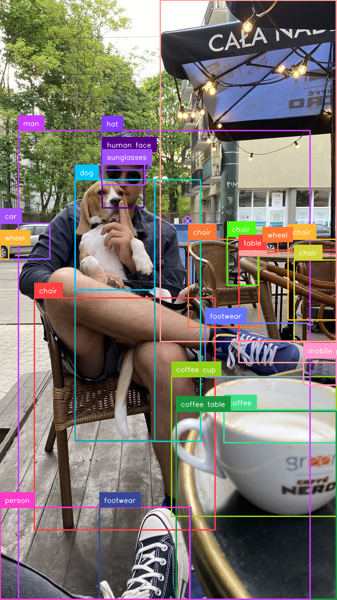

In [ ]:
# @title Example object detection (`<OB>`) inference

import supervision as sv
from PIL import Image

image = Image.open(f"{HOME}/data/dog-3.jpeg")
text = "<OD>"
task = "<OD>"

inputs = processor(text=text, images=image, return_tensors="pt").to(DEVICE)
generated_ids = model.generate(
    input_ids=inputs["input_ids"],
    pixel_values=inputs["pixel_values"],
    max_new_tokens=1024,
    num_beams=3
)
generated_text = processor.batch_decode(generated_ids, skip_special_tokens=False)[0]
response = processor.post_process_generation(generated_text, task=task, image_size=image.size)
detections = sv.Detections.from_lmm(sv.LMM.FLORENCE_2, response, resolution_wh=image.size)

bounding_box_annotator = sv.BoundingBoxAnnotator(color_lookup=sv.ColorLookup.INDEX)
label_annotator = sv.LabelAnnotator(color_lookup=sv.ColorLookup.INDEX)

image = bounding_box_annotator.annotate(image, detections)
image = label_annotator.annotate(image, detections)
image.thumbnail((600, 600))
image

**NOTE:** Note that out of the box Florence-2 detects far more classes than the typical model pretreated on the COCO dataset.

In [ ]:
 # @title Wrap inference code into utility function

def run_inference(image: Image, task: str, text: str = ""):
    prompt = task + text
    inputs = processor(text=prompt, images=image, return_tensors="pt").to(DEVICE)
    generated_ids = model.generate(
        input_ids=inputs["input_ids"],
        pixel_values=inputs["pixel_values"],
        max_new_tokens=1024,
        num_beams=3
    )
    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=False)[0]
    return processor.post_process_generation(generated_text, task=task, image_size=image.size)

**NOTE:** Florence-2 offers 3 types of imag caption tasks - `<CAPTION>`, `<DETAILED_CAPTION>`, `<MORE_DETAILED_CAPTION>` differing in level of detail. Let's compare the results obtained.

In [ ]:
# @title Example `<CAPTION>` inference

import supervision as sv
from PIL import Image

image = Image.open(f"{HOME}/data/dog-3.jpeg")
task = "<CAPTION>"

response = run_inference(image=image, task=task)
response

{'<CAPTION>': 'A man sitting in a chair holding a dog.'}

In [ ]:
# @title Example `<DETAILED_CAPTION>` inference

import supervision as sv
from PIL import Image

image = Image.open(f"{HOME}/data/dog-3.jpeg")
task = "<DETAILED_CAPTION>"

response = run_inference(image=image, task=task)
response

{'<DETAILED_CAPTION>': 'In this image I can see a person sitting on the chair and holding a dog. There is a cup and a mobile on the table. There are chairs and tables. At the back there is a building and there are trees.'}

In [ ]:
# @title Example `<MORE_DETAILED_CAPTION>` inference

import supervision as sv
from PIL import Image

image = Image.open(f"{HOME}/data/dog-3.jpeg")
task = "<MORE_DETAILED_CAPTION>"

response = run_inference(image=image, task=task)
response

{'<MORE_DETAILED_CAPTION>': 'A man is sitting outside on a wicker chair. He is wearing a black cap, sunglasses and a blue shirt. The man is holding a brown and white dog in his lap. There is a black table in front of the man with a white coffee cup on it. Part of a building can be seen behind the man. Large green trees are standing on the side of the building.'}

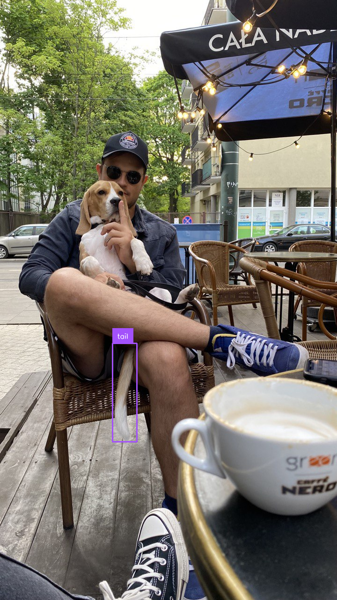

In [ ]:
# @title Example `<CAPTION_TO_PHRASE_GROUNDING>` inference

import supervision as sv
from PIL import Image

image = Image.open(f"{HOME}/data/dog-3.jpeg")
task = "<CAPTION_TO_PHRASE_GROUNDING>"
text = "tail"

response = run_inference(image=image, task=task, text=text)
detections = sv.Detections.from_lmm(sv.LMM.FLORENCE_2, response, resolution_wh=image.size)

bounding_box_annotator = sv.BoundingBoxAnnotator(color_lookup=sv.ColorLookup.INDEX)
label_annotator = sv.LabelAnnotator(color_lookup=sv.ColorLookup.INDEX)

image = bounding_box_annotator.annotate(image, detections)
image = label_annotator.annotate(image, detections)
image.thumbnail((600, 600))
image

In this image I can see a person sitting on the chair and holding a dog. There is a cup and a mobile on the table. There are chairs and tables. At the back there is a building and there are trees.


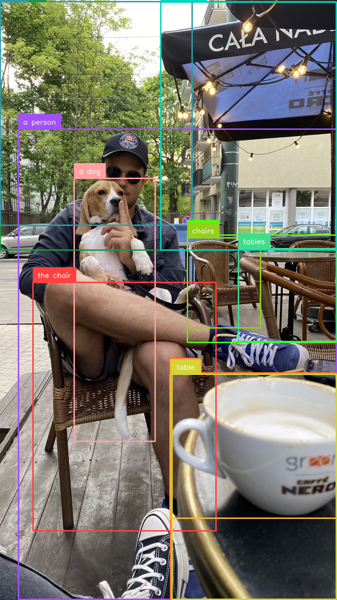

In [ ]:
# @title Example `<DETAILED_CAPTION>` + `<CAPTION_TO_PHRASE_GROUNDING>` combo inference

import supervision as sv
from PIL import Image

image = Image.open(f"{HOME}/data/dog-3.jpeg")
task = "<DETAILED_CAPTION>"

response = run_inference(image=image, task=task)
text = response[task]

task = "<CAPTION_TO_PHRASE_GROUNDING>"

response = run_inference(image=image, task=task, text=text)
detections = sv.Detections.from_lmm(sv.LMM.FLORENCE_2, response, resolution_wh=image.size)

bounding_box_annotator = sv.BoundingBoxAnnotator(color_lookup=sv.ColorLookup.INDEX)
label_annotator = sv.LabelAnnotator(color_lookup=sv.ColorLookup.INDEX)

image = bounding_box_annotator.annotate(image, detections)
image = label_annotator.annotate(image, detections)
image.thumbnail((600, 600))

print(text)
image

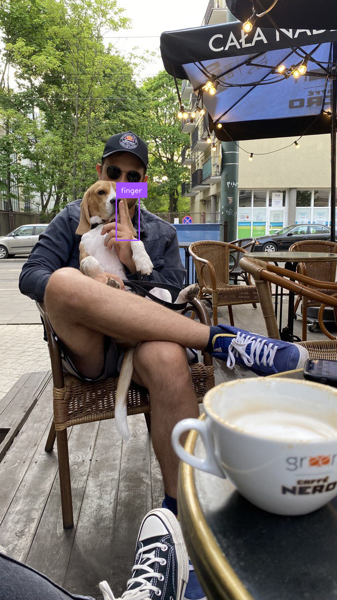

In [ ]:
# @title Example `<OPEN_VOCABULARY_DETECTION>` inference

import supervision as sv
from PIL import Image

image = Image.open(f"{HOME}/data/dog-3.jpeg")
task = "<OPEN_VOCABULARY_DETECTION>"
text = "finger"

response = run_inference(image=image, task=task, text=text)
detections = sv.Detections.from_lmm(sv.LMM.FLORENCE_2, response, resolution_wh=image.size)

bounding_box_annotator = sv.BoundingBoxAnnotator(color_lookup=sv.ColorLookup.INDEX)
label_annotator = sv.LabelAnnotator(color_lookup=sv.ColorLookup.INDEX)

image = bounding_box_annotator.annotate(image, detections)
image = label_annotator.annotate(image, detections)
image.thumbnail((600, 600))
image

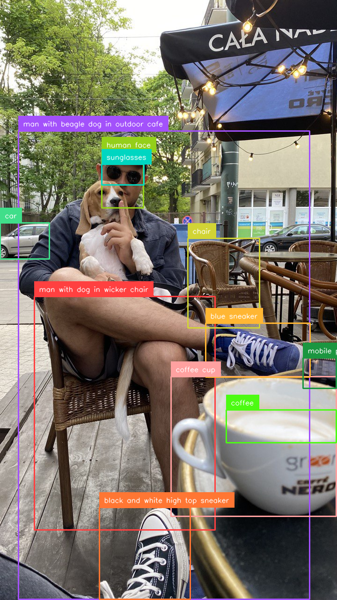

In [ ]:
# @title Example `<DENSE_REGION_CAPTION>` inference

import supervision as sv
from PIL import Image

image = Image.open(f"{HOME}/data/dog-3.jpeg")
task = "<DENSE_REGION_CAPTION>"

response = run_inference(image=image, task=task)
detections = sv.Detections.from_lmm(sv.LMM.FLORENCE_2, response, resolution_wh=image.size)

bounding_box_annotator = sv.BoundingBoxAnnotator(color_lookup=sv.ColorLookup.INDEX)
label_annotator = sv.LabelAnnotator(color_lookup=sv.ColorLookup.INDEX)

image = bounding_box_annotator.annotate(image, detections)
image = label_annotator.annotate(image, detections)
image.thumbnail((600, 600))
image

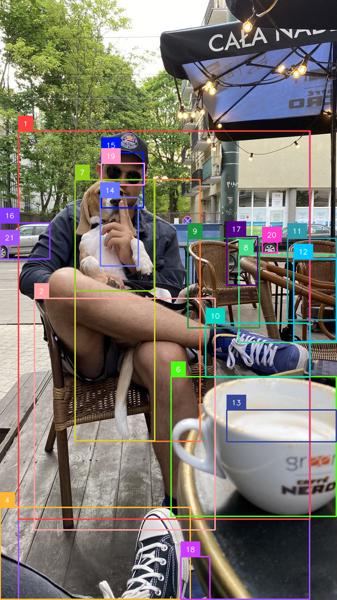

In [ ]:
# @title Example `<REGION_PROPOSAL>` inference

import supervision as sv
from PIL import Image

image = Image.open(f"{HOME}/data/dog-3.jpeg")
task = "<REGION_PROPOSAL>"

response = run_inference(image=image, task=task)
detections = sv.Detections.from_lmm(sv.LMM.FLORENCE_2, response, resolution_wh=image.size)

bounding_box_annotator = sv.BoundingBoxAnnotator(color_lookup=sv.ColorLookup.INDEX)
label_annotator = sv.LabelAnnotator(color_lookup=sv.ColorLookup.INDEX)

image = bounding_box_annotator.annotate(image, detections)
image = label_annotator.annotate(image, detections)
image.thumbnail((600, 600))
image

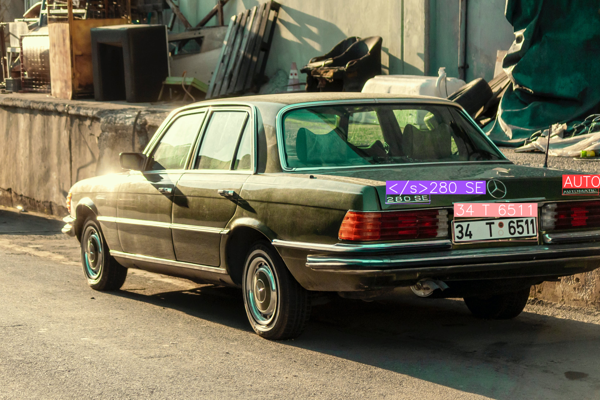

In [ ]:
# @title Example `<OCR_WITH_REGION>` inference

import supervision as sv
from PIL import Image

image = Image.open(f"{HOME}/data/license_plate_1.jpg")
task = "<OCR_WITH_REGION>"

response = run_inference(image=image, task=task)
detections = sv.Detections.from_lmm(sv.LMM.FLORENCE_2, response, resolution_wh=image.size)

bounding_box_annotator = sv.BoundingBoxAnnotator(color_lookup=sv.ColorLookup.INDEX)
label_annotator = sv.LabelAnnotator(
    color_lookup=sv.ColorLookup.INDEX,
    text_scale=3,
    text_thickness=4
)

image = bounding_box_annotator.annotate(image, detections)
image = label_annotator.annotate(image, detections)
image.thumbnail((600, 600))
image

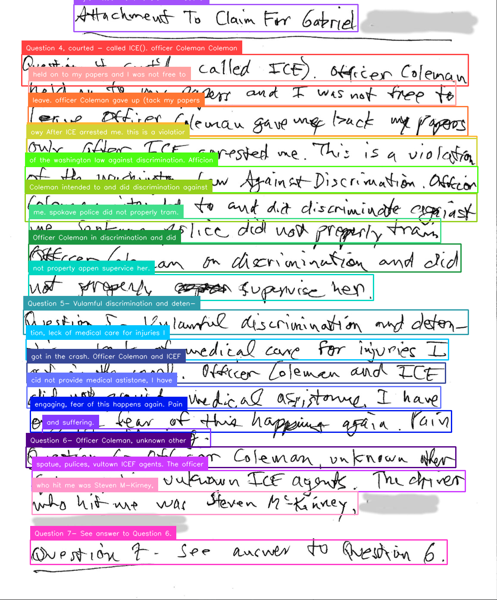

In [ ]:
import supervision as sv
from PIL import Image

image = Image.open(f"{HOME}/data/handwritten-text.jpg")
task = "<OCR_WITH_REGION>"

response = run_inference(image=image, task=task)
detections = sv.Detections.from_lmm(sv.LMM.FLORENCE_2, response, resolution_wh=image.size)

bounding_box_annotator = sv.BoundingBoxAnnotator(color_lookup=sv.ColorLookup.INDEX)
label_annotator = sv.LabelAnnotator(color_lookup=sv.ColorLookup.INDEX)

image = bounding_box_annotator.annotate(image, detections)
image = label_annotator.annotate(image, detections)
image.thumbnail((600, 600))
image

In [ ]:
# @title Example `<OCR>` inference

import supervision as sv
from PIL import Image

image = Image.open(f"{HOME}/data/handwritten-text.jpg")
task = "<OCR>"

response = run_inference(image=image, task=task)
response[task]

'Attachment To Claim For GatrielQuestion 4, cortfd - called ICE). officer Coleman Colemanheld on to my papers and I was not free toleave. Officer Coleman gave up (tuck my papersowy after ICE arrest me. This is a violationof the washington law against discrimination. AfficiorColeman intended to and did not discrimination exceptiastme. spokave police did not properly tran.Officer Coleman in discrimination and dichot property appen supervice her.Question 5- Vulamful discrimination and deten-tion, lack of medical care for injuries Igot in the crash. OfficerColeman and ICEFCid not provide medical astistone, I haveengaging fear of this happiness again. Painand suffering.Question 6- Officer Coleman, unknown otherspatue, pulices, vultown ICE agents. The officerwho hit me was Steven M-kirney,Question 7- See answer to Question 6.'

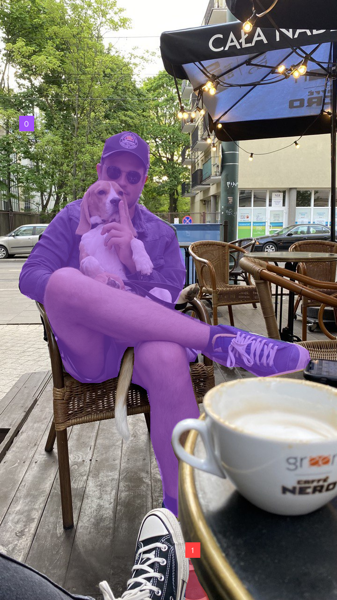

In [ ]:
# @title Example `<REFERRING_EXPRESSION_SEGMENTATION>` inference

import supervision as sv
from PIL import Image

image = Image.open(f"{HOME}/data/dog-3.jpeg")
task = "<REFERRING_EXPRESSION_SEGMENTATION>"
text = "man"

response = run_inference(image=image, task=task, text=text)
detections = sv.Detections.from_lmm(sv.LMM.FLORENCE_2, response, resolution_wh=image.size)

mask_annotator = sv.MaskAnnotator(color_lookup=sv.ColorLookup.INDEX)
label_annotator = sv.LabelAnnotator(color_lookup=sv.ColorLookup.INDEX)

image = mask_annotator.annotate(image, detections)
image = label_annotator.annotate(image, detections)
image.thumbnail((600, 600))
image

In [ ]:
!pip install -q jupyter_bbox_widget

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 220.7/220.7 kB 23.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 842.5/842.5 kB 61.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 84.6 MB/s eta 0:00:00


In [ ]:
import base64

def encode_image(filepath):
    with open(filepath, 'rb') as f:
        image_bytes = f.read()
    encoded = str(base64.b64encode(image_bytes), 'utf-8')
    return "data:image/jpg;base64,"+encoded

In [ ]:
IS_COLAB = True
IMAGE_PATH = f"{HOME}/data/dog-3.jpeg"

if IS_COLAB:
    from google.colab import output
    output.enable_custom_widget_manager()

from jupyter_bbox_widget import BBoxWidget

widget = BBoxWidget()
widget.image = encode_image(IMAGE_PATH)
widget

BBoxWidget(colors=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#b…

In [ ]:
widget.bboxes

[{'x': 185, 'y': 273, 'width': 155, 'height': 204, 'label': ''}]

In [ ]:
import numpy as np

# default_box is going to be used if you will not draw any box on image above
default_box = {'x': 243, 'y': 733, 'width': 52, 'height': 211, 'label': ''}

box = widget.bboxes[0] if widget.bboxes else default_box
box = np.array([
    box['x'],
    box['y'],
    box['x'] + box['width'],
    box['y'] + box['height']
])

image = Image.open(IMAGE_PATH)
w, h = image.size
box = box / np.array([w, h, w, h])
box = box * 1000
box = box.astype(np.int32)
box

array([256, 213, 472, 372], dtype=int32)

In [ ]:
region = "".join([f"<loc_{coordinate}>" for coordinate in box])
region

'<loc_256><loc_213><loc_472><loc_372>'

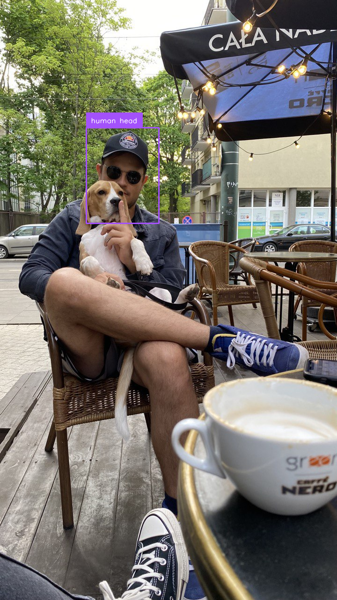

In [ ]:
# @title Example `<REGION_TO_CATEGORY>` inference

import supervision as sv
from PIL import Image

task = "<REGION_TO_CATEGORY>"
image = Image.open(IMAGE_PATH)

response = run_inference(image=image, task=task, text=region)
detections = sv.Detections.from_lmm(sv.LMM.FLORENCE_2, response, resolution_wh=image.size)
detections.xyxy = (detections.xyxy / 1000 * np.array([w, h, w, h])).astype(np.int32)

bounding_box_annotator = sv.BoundingBoxAnnotator(color_lookup=sv.ColorLookup.INDEX)
label_annotator = sv.LabelAnnotator(color_lookup=sv.ColorLookup.INDEX)

image = bounding_box_annotator.annotate(image, detections)
image = label_annotator.annotate(image, detections)

image.thumbnail((600, 600))
image

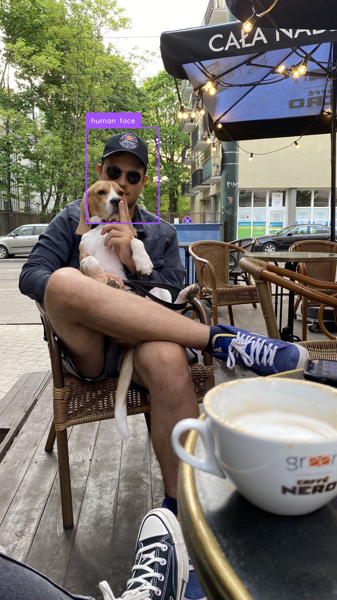

In [ ]:
# @title Example `<REGION_TO_DESCRIPTION>` inference

import supervision as sv
from PIL import Image

task = "<REGION_TO_DESCRIPTION>"
image = Image.open(IMAGE_PATH)

response = run_inference(image=image, task=task, text=region)
detections = sv.Detections.from_lmm(sv.LMM.FLORENCE_2, response, resolution_wh=image.size)
detections.xyxy = (detections.xyxy / 1000 * np.array([w, h, w, h])).astype(np.int32)

bounding_box_annotator = sv.BoundingBoxAnnotator(color_lookup=sv.ColorLookup.INDEX)
label_annotator = sv.LabelAnnotator(color_lookup=sv.ColorLookup.INDEX)

image = bounding_box_annotator.annotate(image, detections)
image = label_annotator.annotate(image, detections)

image.thumbnail((600, 600))
image

# Congratulations

⭐️ If you enjoyed this notebook, [**star the Roboflow Notebooks repo**](https://https://github.com/roboflow/notebooks) (and [**supervision**](https://github.com/roboflow/supervision) while you're at it) and let us know what tutorials you'd like to see us do next. ⭐️